In [1]:
!pip install transformers


[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
!pip install sentence-transformers


[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import torch
from torch.utils.data import Dataset
from torch import nn
import numpy as np
from torch.utils.data import DataLoader
import lightning.pytorch as pl
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2
import h5py
import io
from PIL import Image
import matplotlib.pyplot as plt
import torchvision
import shutil
import os
from sentence_transformers import SentenceTransformer
from torch.utils.data import ConcatDataset
from torchvision.models import vgg19

In [2]:
def createDatasetWithMPNetEmbeddings(hdf5_file, device):
    if (os.path.exists(hdf5_file[0:-5] + '(new embeddings).hdf5')):
        return print('The dataset is already exist')
    else:
        shutil.copyfile(hdf5_file, hdf5_file[0:-5] + '(new embeddings).hdf5')
        dataset = h5py.File(hdf5_file[0:-5] + '(new embeddings).hdf5', mode='r+')
        encoder = SentenceTransformer('all-mpnet-base-v2', device=device)
        for datatype in dataset.keys():
            for example_name in dataset[datatype].keys():
                example = dataset[datatype][example_name]
                text = str(np.array(example['txt']))[2:-3]
                embeddings = encoder.encode([text])[0]
                del dataset[datatype][example_name]['embeddings']
                dataset[datatype][example_name]['embeddings'] = embeddings
        dataset.close()

In [3]:
createDatasetWithMPNetEmbeddings('flowers.hdf5', 'cuda')

The dataset is already exist


In [44]:
class Text2ImageDataset(Dataset):
    def __init__(self,
                 datasetFile,
                 image_size,
                 transform=None,
                 datatype='train'):
      self.datasetFile = datasetFile
      self.transform = transform
      self.dataset = h5py.File(self.datasetFile, mode='r')
      self.datatype = datatype
      self.dataset_keys = [str(k) for k in self.dataset[datatype].keys()]
      self.resize_transform = A.Compose([
          A.Resize(height=image_size, width=image_size, interpolation=cv2.INTER_LANCZOS4, always_apply=True),
      ])

    def __len__(self):
        return len(self.dataset[self.datatype])

    def __getitem__(self, idx):
        example_name = self.dataset_keys[idx]
        example = self.dataset[self.datatype][example_name]

        right_image = bytes(np.array(example['img']))
        right_image = np.array(Image.open(io.BytesIO(right_image)))
        right_txt = str(np.array(example['txt']))
        right_embed = np.array(example['embeddings'], dtype=float)
        right_embed = torch.tensor(right_embed, dtype=torch.float32)
        
        wrong_example = self.getWrongImageTextEmbedding(example['class'])
        wrong_image = bytes(np.array(wrong_example['img']))
        wrong_image = np.array(Image.open(io.BytesIO(wrong_image)))
        wrong_embed = wrong_example['embeddings']
        wrong_embed = torch.tensor(wrong_embed, dtype=torch.float32)

        if(len(right_image.shape) < 3):
          right_image = cv2.cvtColor(right_image[:, :, None], cv2.COLOR_GRAY2RGB)
        
        if(len(wrong_image.shape) < 3):
          wrong_image = cv2.cvtColor(wrong_image[:, :, None], cv2.COLOR_GRAY2RGB)

        right_image = self.resize_transform(image=right_image)['image']
        wrong_image = self.resize_transform(image=wrong_image)['image']

        if(self.transform):
          right_image = self.transform(image=right_image)['image']
          wrong_image = self.transform(image=wrong_image)['image']

        sample = {
                'right_images': right_image,
                'right_embeddings': right_embed,
                'wrong_images': wrong_image,
                'wrong_embeddings' : wrong_embed,
                'right_txt': right_txt
                 }

        return sample

    def getWrongImageTextEmbedding(self, category):
        idx = np.random.randint(len(self.dataset_keys))
        example_name = self.dataset_keys[idx]
        example = self.dataset[self.datatype][example_name]
        _category = example['class']

        if _category != category:
            return example

        return self.getWrongImageTextEmbedding(category)

In [45]:
# -------------------
# Step 2: Define train, validation, test data in DataModule
# -------------------

class DataModule(pl.LightningDataModule):
    def __init__(self,
                 h5pyfile,
                 image_size,
                 batch_size):
      super().__init__()
      self.h5pyfile = h5pyfile
      self.batch_size = batch_size
      self.image_size = image_size
      self.train_transform = A.Compose([
          #A.HorizontalFlip(p=0.75),
          #A.HueSaturationValue(hue_shift_limit=(0, 0), sat_shift_limit=(0, 30), val_shift_limit=(0, 20), p=0.5),
          #A.Sharpen(alpha=(0, 0.30), lightness=(0, 0), p=0.5),
          A.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
          ToTensorV2()
      ])
      self.val_transform = A.Compose([
          A.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
          ToTensorV2()
      ])
    
    def setup(self, stage=None):
      self.train_dataset = Text2ImageDataset(self.h5pyfile, self.image_size, self.train_transform, 'train')
      self.val_dataset = Text2ImageDataset(self.h5pyfile, self.image_size, self.val_transform, 'valid')
      #self.train_dataset = ConcatDataset([self.train_dataset, self.val_dataset]) # we'll concat two datasets because we don't need val dataset during training GAN
      self.test_dataset = Text2ImageDataset(self.h5pyfile, self.image_size, self.val_transform, 'test')

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=False, num_workers=0)
    
    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False, num_workers=0)

In [46]:
# --------------------------------
# Step 3: Build your network
# --------------------------------
class Conv2D(nn.Module):
    def __init__(self, 
                 in_channels,
                 out_channels,
                 kernel_size,
                 stride,
                 padding,
                 activation=nn.ReLU,
                 batch_norm=nn.BatchNorm2d,
                 if_act=True,
                 if_batch_norm=True):
        super().__init__()
        layers = []
        conv2D = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
        layers.append(conv2D)
        if(if_batch_norm):
            layers.append(batch_norm(out_channels, affine=True))
        if(if_act):
            layers.append(activation)
        self.convolution2D = nn.Sequential(*layers)

    def forward(self, x):
        return self.convolution2D(x)

In [47]:
class ConvTranspose2D(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 stride,
                 padding,
                 activation,
                 if_act=True,
                 if_batch_norm=True):
        super().__init__()
        layers = []
        conv_tr_2d = nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
        batch_norm = nn.BatchNorm2d(out_channels)
        layers.append(conv_tr_2d)
        if(if_batch_norm):
            layers.append(batch_norm)
        if(if_act):
            layers.append(activation)
        self.conv_transpose2d = nn.Sequential(*layers)

    def forward(self, x):
        return self.conv_transpose2d(x)

In [48]:
class LinearProjection(nn.Module):
    def __init__(self,
                 in_embedding_dim,
                 projected_embedding_dim,
                 activation):
        super().__init__()
        projection = nn.Linear(in_features=in_embedding_dim, out_features=projected_embedding_dim)
        batch_norm = nn.BatchNorm1d(projected_embedding_dim)
        self.linear_proj = nn.Sequential(projection, batch_norm, activation)

    def forward(self, x):
        return self.linear_proj(x)

In [49]:
class Generator(nn.Module):
  def __init__(self,
               in_embedding_dim,
               projected_embedding_dim,
               noise_dim,
               channels_dim,
               out_channels):
    super(Generator, self).__init__()
    concat_dim = projected_embedding_dim + noise_dim
    self.linear_projection = LinearProjection(in_embedding_dim=in_embedding_dim, projected_embedding_dim=projected_embedding_dim, activation = nn.LeakyReLU(negative_slope=0.2, inplace=True))
    self.generator = nn.Sequential(ConvTranspose2D(in_channels=concat_dim, out_channels=channels_dim * 8, kernel_size=4, stride=1, padding=0, activation=nn.ReLU(inplace=True)),
                                   # Output: (channels_dim*8) x 4 x 4
                                   ConvTranspose2D(in_channels=channels_dim * 8, out_channels=channels_dim * 4, kernel_size=4, stride=2, padding=1, activation=nn.ReLU(inplace=True)), # Output: (channels_dim*4) x 8 x 8
                                   ConvTranspose2D(in_channels=channels_dim * 4, out_channels=channels_dim * 2, kernel_size=4, stride=2, padding=1, activation=nn.ReLU(inplace=True)), # Output: (channels_dim*2) x 16 x 16                                  
                                   ConvTranspose2D(in_channels=channels_dim * 2, out_channels=channels_dim, kernel_size=4, stride=2, padding=1, activation=nn.ReLU(inplace=True)), # Output: (channels_dim) x 32 x 32                                  
                                   ConvTranspose2D(in_channels=channels_dim, out_channels=out_channels, kernel_size=4, stride=2, padding=1, activation=nn.Tanh(), if_batch_norm=False) # Output: (out_channels) x 64 x 64
                                  )
  
  def forward(self, input_embedding, noise):
    x = self.linear_projection(input_embedding).unsqueeze(2).unsqueeze(3)
    x = torch.cat([x, noise], 1)
    x = self.generator(x)
    return x

class Discriminator(nn.Module):
  def __init__(self,
               in_channels,
               channels_dim,
               out_embedding_dim,
               out_projected_embedding_dim):
    super(Discriminator, self).__init__()
    self.discriminator = nn.Sequential(Conv2D(in_channels=in_channels, out_channels=channels_dim, kernel_size=4, stride=2, padding=1, activation=nn.LeakyReLU(negative_slope=0.2, inplace=True), if_batch_norm=False),
                                       Conv2D(in_channels=channels_dim, out_channels=channels_dim * 2, kernel_size=4, stride=2, padding=1, activation=nn.LeakyReLU(negative_slope=0.2, inplace=True), batch_norm=nn.BatchNorm2d),
                                       Conv2D(in_channels=channels_dim * 2, out_channels=channels_dim * 4, kernel_size=4, stride=2, padding=1, activation=nn.LeakyReLU(negative_slope=0.2, inplace=True), batch_norm=nn.BatchNorm2d),
                                       Conv2D(in_channels=channels_dim * 4, out_channels=channels_dim * 8, kernel_size=4, stride=2, padding=1, activation=nn.LeakyReLU(negative_slope=0.2, inplace=True), batch_norm=nn.BatchNorm2d)
                                      )
    self.linear_projection = LinearProjection(in_embedding_dim=out_embedding_dim, projected_embedding_dim=out_projected_embedding_dim, activation = nn.LeakyReLU(negative_slope=0.2, inplace=True))
    self.last_conv2d_1 = Conv2D(in_channels=(channels_dim * 8) + out_projected_embedding_dim, out_channels=channels_dim * 8, kernel_size=1, stride=1, padding=0, activation=nn.LeakyReLU(negative_slope=0.2, inplace=True), batch_norm=nn.BatchNorm2d)
    self.last_conv2d_2 = Conv2D(in_channels=channels_dim * 8, out_channels=1, kernel_size=4, stride=1, padding=0, if_act=False, if_batch_norm=False)
    self.sigmoid_act = nn.Sigmoid()
    
  def forward(self, input_image, input_embedding):
    x_d = self.discriminator(input_image)
    projected_embedding = self.linear_projection(input_embedding)
    replicated_embedding = projected_embedding.repeat(4, 4, 1, 1).permute(2, 3, 0, 1)
    x = torch.cat([x_d, replicated_embedding], 1)
    x = self.last_conv2d_1(x)
    x = self.last_conv2d_2(x)
    x = self.sigmoid_act(x)
    return torch.flatten(x), x_d

In [50]:
class FeaturesFromVGG19(nn.Module):
  def __init__(self,
               device):
    super().__init__()
    vgg = vgg19(pretrained=True).to(device)
    self.vgg = nn.Sequential(*list(vgg.features)[:-3]).eval() # last conv features before activation
    for p in self.vgg.parameters():
      p.requires_grad = False
    self.normalize_input = torchvision.transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))

  def forward(self, x):
    x = self.normalize_input(x)
    return self.vgg(x)

In [51]:
class VGGLoss(nn.Module):
    def __init__(self):
        super(VGGLoss, self).__init__()
        self.layer_ids = [3, 8, 15, 22, 29]
        self.loss_weights = [1.0, 0.75, 0.5, 0.25, 0.1]
        self.model = vgg19(pretrained=True).features[:max(self.layer_ids) + 1].to(device)
        self.criterion = nn.MSELoss()
        self.normalize_input = torchvision.transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))

    def forward(self, input, target):
        input = self.normalize_input(input)
        target = self.normalize_input(target)
        input_features = self.model(input)
        target_features = self.model(target)

        loss = 0
        for i, layer_id in enumerate(self.layer_ids):
            input_feat = input_features[layer_id]
            target_feat = target_features[layer_id]
            loss = self.loss_weights[i] * self.criterion(input_feat, target_feat) + loss
        return loss

In [52]:
# --------------------------------
# Step 4: Compile your model
# --------------------------------
class ModelCompilation(pl.LightningModule):
    def __init__(self,
                 model,
                 z_dim,
                 optimizer,
                 learning_rate,
                 l1_coeff,
                 l2_coeff_fm_d,
                 l2_coeff_fm_vgg):
        super().__init__()
        self.generator = model['generator']
        self.discriminator = model['discriminator']
        self.g_learning_rate = learning_rate['generator']
        self.d_learning_rate = learning_rate['discriminator']
        self.z_dim = z_dim
        self.optimizer = optimizer
        self.automatic_optimization = False

        self.initialize_weights(self.generator)
        self.initialize_weights(self.discriminator)
        
        self.bce_loss = nn.BCELoss()
        self.l2_loss = nn.MSELoss()
        self.l1_loss = nn.L1Loss()
        self.l1_coeff = l1_coeff
        self.l2_coeff_fm_d = l2_coeff_fm_d
        self.l2_coeff_fm_vgg = l2_coeff_fm_vgg

        self.vgg = FeaturesFromVGG19(device)
        #self.vgg_loss = VGGLoss()

    def forward(self, x):
      pass
    
    def configure_optimizers(self):
        self.gen_optimizer = self.optimizer(self.generator.parameters(), lr=self.g_learning_rate, betas=(0.5, 0.99))
        self.dis_optimizer = self.optimizer(self.discriminator.parameters(), lr=self.d_learning_rate, betas=(0.5, 0.99))
        return [self.gen_optimizer, self.dis_optimizer], []

    def training_step(self, batch, batch_idx):
      right_images = batch['right_images'].to(device)
      right_embeddings = batch['right_embeddings'].to(device)
      wrong_images = batch['wrong_images'].to(device)
      wrong_embeddings = batch['wrong_embeddings'].to(device)

      right_labels = torch.ones(right_images.size(0)).to(device)
      fake_labels = torch.zeros(right_images.size(0)).to(device)

      ################## Train Discriminator########################
      self.dis_optimizer.zero_grad()
      right_outputs, _ = self.discriminator(right_images, right_embeddings)
      real_loss = self.bce_loss(right_outputs, right_labels-0.1)

      noise = torch.randn(right_images.size(0), self.z_dim, 1, 1).to(device)
      fake_images = self.generator(right_embeddings, noise)
      fake_outputs, _ = self.discriminator(fake_images, right_embeddings)
      fake_loss = self.bce_loss(fake_outputs, fake_labels)
    
      wrong_img_outputs, _ = self.discriminator(wrong_images, right_embeddings)
      wrong_text_outputs, _  = self.discriminator(right_images, wrong_embeddings)
      wrong_loss = 0.5*(self.bce_loss(wrong_img_outputs, fake_labels) + self.bce_loss(wrong_text_outputs, fake_labels))

      d_loss = real_loss + fake_loss + wrong_loss
        
      self.manual_backward(d_loss)
      self.dis_optimizer.step()

      ################## Train Generator########################
      self.gen_optimizer.zero_grad()
      noise = torch.randn(right_images.size(0), self.z_dim, 1, 1).to(device)
      fake_images = self.generator(right_embeddings, noise)
      fake_outputs, activation_fake = self.discriminator(fake_images, right_embeddings)
      right_outputs, activation_real = self.discriminator(right_images, right_embeddings)
      
      activation_fake = torch.mean(activation_fake, 0)
      activation_real = torch.mean(activation_real, 0)

      bce_loss = self.bce_loss(fake_outputs, right_labels)
      l1_loss = self.l1_coeff * self.l1_loss(fake_images, right_images)
      l2_disc_fn_loss = self.l2_coeff_fm_d * self.l2_loss(activation_fake, activation_real.detach())
      l2_vgg_fn_loss = self.l2_coeff_fm_vgg * self.l2_loss(self.vgg(right_images), self.vgg(fake_images))
      #l2_vgg_fn_loss = self.vgg_loss(fake_images, right_images)

      g_loss = bce_loss + l2_disc_fn_loss + l1_loss  + l2_vgg_fn_loss

      self.manual_backward(g_loss)
      self.gen_optimizer.step()

      ################## LOGGING ########################
      self.log('train_generator_' + 'loss', g_loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
      self.log('train_discriminator_' + 'loss', d_loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)

      self.fake = fake_images
      self.right = right_images

    def on_train_epoch_end(self):
        grid = torchvision.utils.make_grid(self.fake[:24, ...], nrow=4, normalize=True, scale_each=True)
        fig = plt.figure(figsize=(10, 10))
        plt.imshow(np.moveaxis(grid.detach().cpu().numpy(), 0, -1), aspect='auto')
        plt.axis('off')
        plt.savefig('sample_' + str(self.current_epoch) + '.png')

    def initialize_weights(self, model):
        # Initializes weights according to the DCGAN paper
        for m in model.modules():
            if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
                nn.init.normal_(m.weight.data, 0.0, 0.02)

In [53]:
# -------------------
# Step 5: Init your DataModule
# -------------------

batch_size = 64
image_size = 64
data_module = DataModule(h5pyfile='flowers(new embeddings).hdf5', image_size=image_size, batch_size=batch_size)

In [13]:
# -------------------
# Step 7: Init your model and its trainer with callbacks
# -------------------

device = 'cuda'
embedding_dim = 768

generator = Generator(in_embedding_dim=embedding_dim,
                      projected_embedding_dim=128,
                      noise_dim=100,
                      channels_dim=64,
                      out_channels=3)

discriminator = Discriminator(in_channels=3,
                channels_dim=64,
                out_embedding_dim=embedding_dim,
                out_projected_embedding_dim=128)

gan = {'generator' : generator, 'discriminator' : discriminator}
optimizer = torch.optim.Adam
learning_rate = {'generator' : 2e-4, 'discriminator' : 2e-4}
zdim = 100
l1_coeff = 50         # for l1 loss - pixel-level difference between the generated image and the target (real) image (default 50)
l2_coeff_fm_d = 100   # for feature matching loss of discriminator (default 100)
l2_coeff_fm_vgg = 0.1   # for feature matching of vgg-19 (default 0)

model = ModelCompilation(gan, zdim, optimizer, learning_rate, l1_coeff, l2_coeff_fm_d, l2_coeff_fm_vgg)
trainer = pl.Trainer(precision='32', accelerator=device, devices="auto", max_epochs=200, enable_checkpointing=True)
# fast debug mode for your model
#trainer = pl.Trainer(precision='32', accelerator=device, devices="auto", fast_dev_run=5)

C:\Users\user\PycharmProjects\pythonProject\venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\user\PycharmProjects\pythonProject\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\user\PycharmProjects\pythonProject\venv\lib\site-packages\lightning\pytorch\trainer\connectors\logger_connector\logger_connector.py:67: UserWarning: Starting from v1.9.

In [47]:
# -------------------
# Step 8: Train your model
# -------------------

trainer.fit(model, datamodule=data_module)

You are using a CUDA device ('NVIDIA GeForce RTX 3060 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type              | Params
----------------------------------------------------
0 | generator     | Generator         | 4.7 M 
1 | discriminator | Discriminator     | 3.2 M 
2 | bce_loss      | BCELoss           | 0     
3 | l2_loss       | MSELoss           | 0     
4 | l1_loss       | L1Loss            | 0     
5 | vgg           | FeaturesFromVGG19 | 17.7 M
----------------------------------------------------
7.9 M     Trainable params
17.7 M    Non-trainable params
25.6 M    Total params
102.326   Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

C:\Users\user\AppData\Local\Temp\ipykernel_7116\4246114292.py:104: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(10, 10))


In [54]:
torch.save(generator.state_dict(), 'generator.pth')

In [55]:
# Loading generator for prediction
generator = Generator(in_embedding_dim=768,
                      projected_embedding_dim=128,
                      noise_dim=100,
                      channels_dim=64,
                      out_channels=3)
generator.load_state_dict(torch.load('generator.pth'))

<All keys matched successfully>

In [56]:
def testing(data_module, index, generator):
    data_module.setup()
    test_dataset = data_module.test_dataset
    sample = test_dataset.__getitem__(index)
    text = sample['right_txt']
    right_image = sample['right_images']
    right_image = (right_image.permute(1, 2, 0) + 1)/2
    right_embedding = sample['right_embeddings']
    noise = torch.randn(1, 100, 1, 1)
    generator.eval()
    generator.to('cpu')
    fake_image = generator(right_embedding[None, :].to('cpu'), noise.to('cpu'))[0]
    fake_image = fake_image.permute(1, 2, 0).detach().numpy()
    fake_image = (fake_image + 1)/2

    print(text)
    fig = plt.figure(figsize=(10, 7))
    rows = 1
    columns = 2
    fig.add_subplot(rows, columns, 1)
    plt.imshow(fake_image)
    plt.axis('off')
    plt.title("Generated")
    fig.add_subplot(rows, columns, 2)
    plt.imshow(right_image)
    plt.axis('off')
    plt.title("Real")
    plt.savefig('saved.png')

b'the petals on this flower are pink with a yellow base.\n'


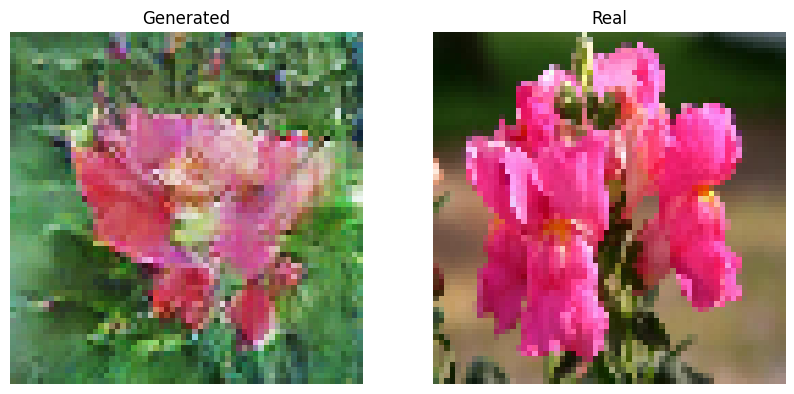

In [57]:
testing(data_module, 130, generator)

In [69]:
def generate_from_text(text, generator):
    encoder = SentenceTransformer('all-mpnet-base-v2', device=device)
    embedding = encoder.encode([text], convert_to_tensor=True)
    noise = torch.randn(1, 100, 1, 1)
    generator.eval()
    generator.to('cpu')
    fake_image = generator(embedding.to('cpu'), noise.to('cpu'))[0]
    fake_image = fake_image.permute(1, 2, 0).detach().numpy()
    fake_image = (fake_image + 1)/2

    fig = plt.figure()
    plt.imshow(fake_image)
    plt.axis('off')
    plt.title("Generated")
    plt.savefig('saved.png')

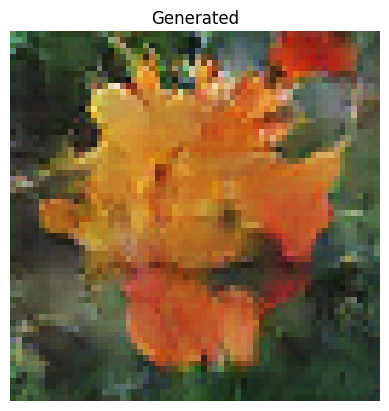

In [70]:
generate_from_text('little orange flower', generator)